In [ ]:
# !pip install imblearn xgboost catboost lightgbm scikit-learn-intelex hyperopt

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
%matplotlib inline

In [2]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import re

import os
from os import path

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Plotting
import IPython.display as ipd

import seaborn as sns 
sns.set_style("whitegrid")
colors = sns.color_palette("coolwarm_r")

palette = [
    "#A79AFF", "#AFCBFF", "#FF9CEE", "#FFCCF9", 
    "#85E3FF", "#ACE7FF", "#AFF8DB", "#DBFFD6", 
    "#E7FFAC", "#FFFFD1", "#FFABAB", "#FFCBC1" 
]

m_color, f_color = "#FFABAB", "#AFCBFF"

In [4]:
# Audio procesing
from scipy.io import wavfile
import noisereduce as nr
from pydub import AudioSegment

import librosa
import librosa.display as ld

from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import MidTermFeatures as MTF

In [5]:
# Stats and Modeling
from scipy.stats import zscore

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA


from sklearn.experimental import enable_halving_search_cv

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, learning_curve, train_test_split, HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
#Predefined paths to use in our functions

CSV_PATH = "/home/faeron/Desktop/ML Exam Project/audio-data"
AUDIO_PATH = "/home/faeron/Desktop/ML Exam Project/csv-folder"

# Sentiment Analysis of Audio Data

#### An end-to-end project for audio machine learning’s foundational application scenario.

### Author: Tihomir Todorov

<br>
<a href="https://imgur.com/31B44bW"><img src="https://i.imgur.com/31B44bW.jpg" title="source: imgur.com" width="800px"/></a><br>

#### Table of Contents:

1. [Introduction](#introduction)


2. [Data Cleaning](#data_cleaning)

    2.1 [Noise Reduction](#noise_reduction)
    
    2.2 [Trimming](#trimming)


3. [Exploratory Data Analysis](#eda)

    3.1 [Exploring the Facets of Audio by Gender](#eda_audio_gender)


    


<a name = "introduction"></a> 

## 1. Introduction

It is common to see a data science project on image, text or tabular data, but no as often we see such on analyzing audio data. In this project, we will explore how to do that. How to prepare, explore, analyze data, and apply machine learning models to predict certain features. In short: As for all other modalities as well, the "problem" always is to get the data into an interpretable format.

The interesting thing with audio data is that you can treat it as a different modality:

- Extract high-level features and analyze the data in a tabular format.

    
- Compute frequency plots and inspect the data like image data.


- Use temporal sensitive models to treat the data like time-series data, etc...

In this noteobok we will look at those three approaches.

<br>

### 1.1 Motivation

I am a musician and a producer, this has been my hobby for many years now, and I am extremely curious about sound, voice, frequencies and their application in Data Science and Machine Learning. Furthermore, I have huge interest in psychology and understanding how A.I can understand sound and voice is going to take a big part in my future career development as a Data Scientist. I realized that besides playing on an instrument or composing virtual sounds, there is a lot to be investigated and explored in the area of sound, and decided to use this project in order to gather a bigger understanding of how sounds are constructed.

<br>

### 1.2 Previous Research

This project was inspired by Michael P. Notter's research published at [Medium](https://medium.com/epfl-extension-school/age-prediction-of-a-speakers-voice-ae9173ceb322)

I decided to improve and expand this research and learn from the great skills of an experienced data professional. Other inspirations and resources will be included at the end of this notebook.

<br>

### 1.3 Our Dataset

For this project we will use the Mozilla's Common Voice 11.0 dataset:

Common Voice is a corpus of speech data read by users on the Common Voice website (http://voice.mozilla.org/), and based upon text from a number of public domain sources like user submitted blog posts, old books, movies, and other public speech corpora. Its primary purpose is to enable the training and testing of automatic speech recognition (ASR) systems.

- **The corpus contains 2,161,672 audio files and various .tsv (tab-separated values) files.**

<br>

### 1.4 The Structure

The corpus is split into several parts for our convenience.

- dev - for development and experimentation
- train - for use in speech recognition training
- test - for testing word error rate

<br>

### 1.5 Organization and Conventions


Each row of a csv file represents a single audio clip, and contains the following information:

    filename - relative path of the audio file
    
    text - supposed transcription of the audio
    
    up_votes - number of people who said audio matches the text
    
    down_votes - number of people who said audio does not match text
    
    age - age of the speaker, if the speaker reported it
        teens: '< 19'
        twenties: '19 - 29'
        thirties: '30 - 39'
        fourties: '40 - 49'
        fifties: '50 - 59'
        sixties: '60 - 69'
        seventies: '70 - 79'
        eighties: '80 - 89'
        nineties: '> 89'
    
    gender - gender of the speaker, if the speaker reported it
        male
        female
        other
    
    accent - accent of the speaker, if the speaker reported it
        us: 'United States English'
        australia: 'Australian English'
        england: 'England English'
        canada: 'Canadian English'
        philippines: 'Filipino'
        hongkong: 'Hong Kong English'
        indian: 'India and South Asia (India, Pakistan, Sri Lanka)'
        ireland: 'Irish English'
        malaysia: 'Malaysian English'
        newzealand: 'New Zealand English'
        scotland: 'Scottish English'
        singapore: 'Singaporean English'
        southatlandtic: 'South Atlantic (Falkland Islands, Saint Helena)'
        african: 'Southern African (South Africa, Zimbabwe, Namibia)'
        wales: 'Welsh English'
        bermuda: 'West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad)'


- **The audio clips for each subset are stored as mp3 files in the "clip" folder with the same naming conventions as it’s corresponding csv file.**


<br>

### 1.6 Acknowledgments

This dataset was compiled by Michael Henretty, Tilman Kamp, Kelly Davis & The Common Voice Team, who included the following acknowledgments:

"We sincerely thank all of the people who donated their voice on the Common Voice website and app. You are the backbone of this project, and we thank you for making this possible!"

<br>

<a name = "data_cleaning"></a>
## 2. Data Cleaning

We will be using [librosa](https://librosa.org/doc/main/index.html) to load and visualize audio data and some of it's features. Librosa is a python package for audio and music analysis.




### Note: 

We can experience a problem when loading the files in librosa as mp3, so let's learn something useful, how to convert .mp3 to .wav in python :) As there are more than 2,161,672 files (excluding the ones with missing value for "gender"), this will be a long process...

- That's why it will be a good idea to reduce our audio data to the amount of observations that contain "gender" information and then see if the classes are imbalanced. If they are, we will most probably undersample and equalize the classes in order to reduce the audio even further.


- Our goal is to obtain aproximately 200,000 observations out of over 2 million, and all of them should contain gender information.

In [ ]:
valid_data = pd.read_csv("validated.tsv", sep = "\t")

In [ ]:
valid_data.head()

In [ ]:
valid_data.info()

In [ ]:
valid_data.gender.isna().value_counts()

- We see that out of 1,617,877 valid audios 575,032 do not contain gender information, therefore we will remove them from the dataset and later from the audio folder.

In [ ]:
valid_data = valid_data[valid_data.gender.notna()]

- As a next step, we should check if our genders are balanced and see if we can reduce the data by undersampling:

In [ ]:
def plot_countplot(data, x, figsize, title, xlabel, ylabel):
    plt.figure(figsize = figsize)
    sns.countplot(x = x, data = data, palette = colors)
    
    plt.title(title, fontsize = 14)
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)
    
    plt.show()

In [ ]:
plot_countplot(valid_data, x = "gender", figsize = (8, 4), title = "Distribution of Genders", xlabel = "Gender", ylabel = "Count")

In [ ]:
valid_data.gender.value_counts()

- Plenty of disbalance, but that will work for our target of 200k samples.


- Let's remove the "other" records first:

In [ ]:
valid_data = valid_data[valid_data.gender != "other"]

- Now we can undersample the dataset so we have 250k records from each:

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy = "majority", random_state = 42)

In [ ]:
def majority_under_sampler(data):
    under_sampler = RandomUnderSampler(sampling_strategy = "majority", random_state = 42)

    data_X, data_Y = under_sampler.fit_resample(data.drop("gender", axis = 1).reset_index(drop = True), data.gender)

    balanced_data = pd.concat([pd.DataFrame(data_Y), pd.DataFrame(data_X)], axis = 1)
    
    return balanced_data

In [ ]:
balanced_data = majority_under_sampler(valid_data)

In [ ]:
plot_countplot(balanced_data, x = "gender", figsize = (8, 4), title = "Distribution of Genders", xlabel = "Gender", ylabel = "Count")

- Good to go! We have more than 500k observations from which we can take a sample to "feed" our model with. Let's remove the columns that we are not going to use and save our file!

In [ ]:
balanced_data = balanced_data[["gender", "path"]]

In [ ]:
# balanced_data.to_csv("balanced_data.csv", index = False)

In [7]:
balanced_data = pd.read_csv("balanced_data.csv")

Now we can take a sample from this file.

In [15]:
sample = balanced_data.sample(n = 200000, random_state = )

In [16]:
sample.gender.value_counts()

male      100347
female     99653
Name: gender, dtype: int64

The number of men and women in the world is roughly equal, though men hold a slight lead with 102 men for 100 women. More precisely, out of 1,000 people, 504 are men (50.4%) and 496 are women (49.6%).

That's why this a very good representation of the population in this sample.

In [20]:
sample.to_csv("balanced_sample.csv", index = False)

In [21]:
data_sample = pd.read_csv("balanced_sample.csv")

In [22]:
data_sample.head(3)

,gender,path
0,male,common_voice_en_25083267.mp3
1,male,common_voice_en_134492.mp3
2,male,common_voice_en_18296826.mp3


Perfect! We are ready for the next step... Deleting the unneeded audio from our audio folder.

In [25]:
def delete_unmatched_files(path, data):

    os.chdir(path)
    audio_files = os.listdir()
    files_deleted = 0

    for file in audio_files:
        name, extension = os.path.splitext(file)
        if file not in data.path.to_list():
            os.remove(file)
            files_deleted += 1
            
    os.chdir(CSV_PATH)
    print(f"{files_deleted} unmatched files deleted from this folder.")

In [27]:
# delete_unmatched_files(AUDIO_PATH, data_sample)
'''1,971,879 unmatched files deleted from this folder.'''

'1,971,879 unmatched files deleted from this folder.'

- Now that we were patient enough to wait for the deletion, Let's continue with our exploration in librosa.

#### By default, librosa resamples the audio file on loading to 22050 Hz. But why?

It's true: $44100 Hz$ is essentially the standard for "high (enough) quality" audio storage, and it would have been a sensible default. However, they decided for the lower rate of $22050 Hz$ for two reasons:

- It cuts down on memory consumption
    

- $44100$ was overkill for the most common tasks

The first point is obvious, but the second point deserves a bit more discussion:

- The highest pitches we usually care about detecting are around $C_9 \approx 8372 Hz$, well below the $11025$ cutoff implied by $fs = 22050$. There's certainly content above $11025 Hz$, but it often turns out to be noisy or redundant with the lower parts of the spectrum, and not so informative for semantic analysis tasks like instrument classification, rhythm analysis, chord recognition, and so on


- More info [here](https://librosa.org/blog/2019/07/17/resample-on-load/)

__Note__:

Due to the conversion of each audio file before loading it, __performing feature exctraction with librosa turns out to be a very slow process for large amounts of data__, as previously tested. That's why we will use another library for that, which we will discuss later.

<br>

<a name = "eda"></a>

## 3. Exploratory Data Analysis - Exploring the Facets of Audio by Gender 

<br>

We are ready to continue, but before exploring our dataset, let's first investigate the many facets of audio files. We will need to do this, in order to understand our data and our future work better.

__Note:__ 

__After reading the metadata of our dataset, we can find that many of the audios have the same words, but either different gender or accent, this will be useful to us. We have pre-selected such two audio files with the same text, but different gender and we will explore the audio characteristics of each, to see what insight we can gain.__


- In this case, we can choose to work with the "thirties" male and female with "english" and "scottish" accent.

When you load a sample in librosa it automatically divides it in two files:

1. Audio time series. Multi-channel is supported


2. The sampling rate (sr) of the file

In [38]:
audio_male, sr_male = librosa.load("test_audio/sample-037769.wav")
audio_female, sr_female = librosa.load("test_audio/sample-000410.wav")

In [39]:
audio_male, audio_female

(array([ 0.        ,  0.        ,  0.        , ..., -0.00100381,
         0.00369414,  0.        ], dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.1845491e-06,
        2.2952217e-05, 0.0000000e+00], dtype=float32))

In [40]:
sr_male, sr_female

(22050, 22050)

- We can see that the audio is returned in float32 type array and the default sample rate is 22050

#### Let's use the IPython.display.Audio to play the random file

In [55]:
ipd.display(ipd.Audio(audio_male, rate = sr_male), ipd.Audio(audio_female, rate = sr_female))

- We can also plot the signal stored in the audio_file variable

In [41]:
 def plot_waveform_signal(audio, sr, title, color):

    plt.figure(figsize = (8, 2))

    ld.waveshow(audio, sr = sr, color = color, alpha = 0.7)

    plt.title(title, fontsize = 14)
    plt.xlabel("Time (s)", fontsize = 10)
    plt.ylabel("Amplitude (dB)", fontsize = 10)

    plt.show()

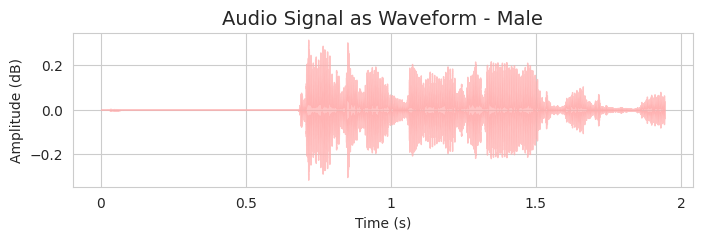

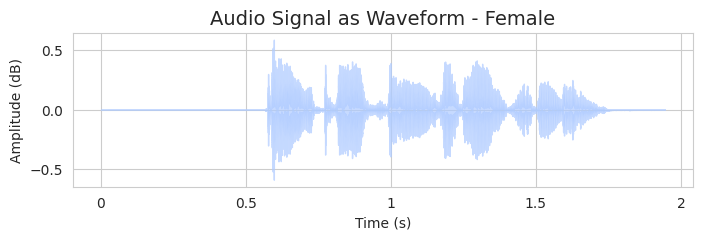

None

None

In [42]:
ipd.display(
    plot_waveform_signal(
        audio = audio_male, 
        sr = sr_male,
        title = "Audio Signal as Waveform - Male",
        color = m_color
    ), 
        plot_waveform_signal(
        audio = audio_female, 
        sr = sr_female,
        title = "Audio Signal as Waveform - Female",
        color = f_color
    )
)

#### What we see here is the **waveform** representation of the spoken sentence: “Don't take any chances”

The amplitude of the female audio reaches higher and lower numbers. This amplitude shows us the relative strength of sound waves (transmitted vibrations), which we perceive as loudness or volume.

- If you play both audios a few times, you can notice that this difference in amplitude is not really easy to perceive by the human ear.


- You can see the obvious difference caused by pronouncing the words in distinct ways, especially the last word - "chances" that looks as two words in the male plot, but it is actually one, just pronounced differently.

<br>
 
Ok, so, first we called it time-series data, but now we name it waveform? Well, it is both. This becomes clearer when we look only at a small segment of this audio file. The following plot shows the same thing as above, but this time only $45$ milliseconds of it.

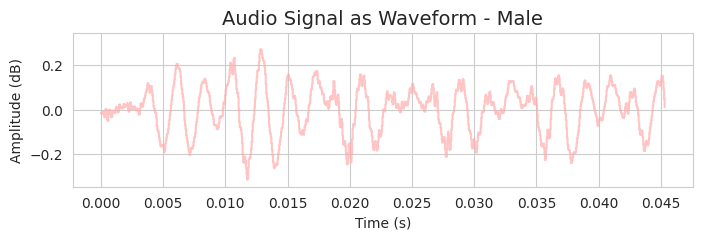

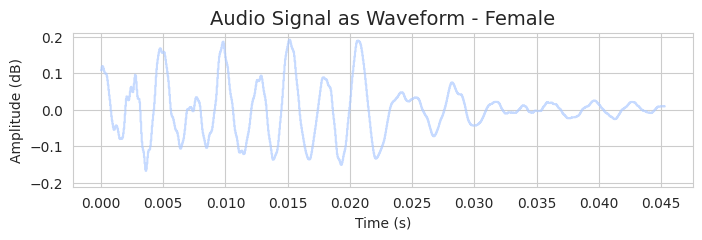

None

None

In [61]:
ipd.display(
    plot_waveform_signal(
        audio = audio_male[15500 : 16500], 
        sr = sr_male,
        title = "Audio Signal as Waveform - Male",
        color = m_color
    ), 
        plot_waveform_signal(
        audio = audio_female[15500 : 16500], 
        sr = sr_female,
        title = "Audio Signal as Waveform - Female",
        color = f_color
    )
)

What we can see is a temporal signal that oscillates around the value 0 with different frequencies and amplitudes.This signal represents the air pressure change over time, or the physical displacement of a loud speaker’s membrane (or the membrane in your ear for that matter). That’s why this depiction of the audio data is also called waveform.


- The frequency is the speed with which this signal oscillates. Low frequency, e.g. $60 Hz$ could be the sound of bass guitar, while a birds song could be in the higher frequency of $8000 Hz$. Human speech is usually anywhere between that.


- To know the interpretation speed of this signal, we also need to know the sampling rate at which the data was recorded. In this case, the sampling rate (after resampling from librosa) per second is $22.050$ or $22 kHz$. Which means that the $1.000$ time points we can see in the previous figure represents $45$ milliseconds $(1000 / 22.050 \approxeq 0.045)$ of audio signal.


- Seems that the male's voice frequency oscillates faster around the 0 line, this might be helpful to know.


<br>

### 3.1.1 The Fast Fourier Transform

- While the previous visualization can tell us when something happens (i.e. between 1 and 5 seconds there seem to be a lot of waveforms), it cannot really tell us with what frequency it happens. Because the waveform shows us information about the when, this signal is also said to be in the time domain

#### The Fast-Fourier transform is a mathematical formula that allows us to decompose a signal into it’s individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a spectrum:

<br>

<div>
<a href="https://imgur.com/Z833qxp"><img src="https://i.imgur.com/Z833qxp.jpg" title="source: imgur.com" width = "840px"/></a>
</div>

#### This is possible because every signal can be decomposed into a set of sine and cosine waves that add up to the original signal. This is a remarkable theorem known as [Fourier’s theorem](https://www.sfu.ca/sonic-studio-webdav/handbook/Fourier_Theorem.html).

<br>

#### Let’s see what our sentence from before looks like, represented in the frequency domain:

In [44]:
def plot_fft(audio, sr, title, color):
    # Applies fast fourier transformation to the signal and takes absolute values
    sample_freq = np.abs(scipy.fftpack.fft(audio))

    # Adding a wrapper around the plot which additionally changes the x-axis to log scaling
    frequencies = np.linspace(0, sr, len(sample_freq))

    plt.figure(figsize = (8, 2))
    plt.semilogx(
        frequencies[: len(frequencies) // 2], 
        sample_freq[: len(frequencies) // 2], 
        color = color, 
        alpha = 0.7
    )
               
    plt.title(title, fontsize = 14)
    plt.xlabel("Frequency (Hz)", fontsize = 10)
    plt.ylabel("Amplitude", fontsize = 10)

    plt.show()

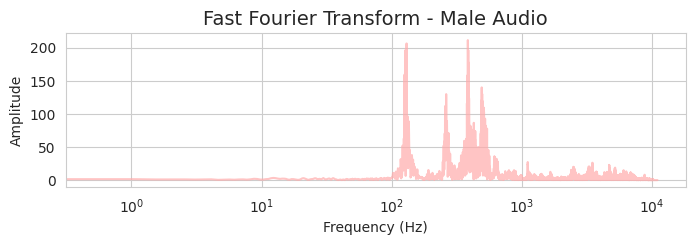

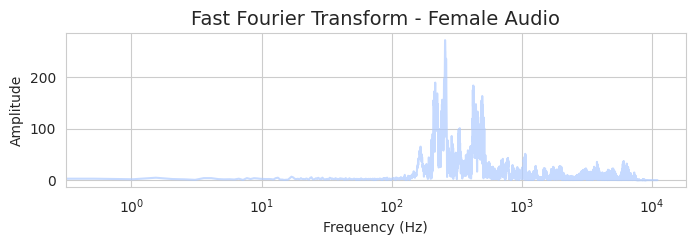

None

None

In [45]:
ipd.display(
    plot_fft(
        audio = audio_male,
        sr = sr_male,
        title = "Fast Fourier Transform - Male Audio",
        color = m_color
    ),
    plot_fft(
        audio = audio_female,
        sr = sr_female,
        title = "Fast Fourier Transform - Female Audio",
        color = f_color
    )
)

What you can see here is that most of the signal is somewhere between $~100 \space and ~1000 Hz$ (i.e. between $10^2$ and $10^3$). Plus there seem to be some additional signals from 1’000 to 10’000 Hz that are stronger in the female voice.

- That makes sense, as female voice is generally produces higher frequencies than male.

<br>

<a name = "spectrogram"></a>
### 3. 1. 2 Spectrograms

Luckily, we don’t always need to decide for either the time or frequency domain. Using a spectrogram plot, we can profit from both domains, while keeping most of their handicaps minimal. There are multiple ways how you can create such spectrogram plots, but for this project we will explore two of them in particular:

<br>
<a name = "stft"></a>

#### Short-Time Fourier Transform

Using a small, adapted version of the fast fourier transformation before, namely the short-time fourier transformation, we can create such a spectrogram. STFT works as the fast fourier transforms are computed for multiple small time windows (hence “short-time fourier”) in a sliding window manner.

In [46]:
def plot_stft(audio, sr, title):
    # Compute short-time Fourier Transform
    x_stft = np.abs(librosa.stft(audio))

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_stft = librosa.amplitude_to_db(x_stft, ref = np.max)

    # Plot STFT spectrogram
    plt.figure(figsize = (6, 3))

    ld.specshow(x_stft, sr = sr, x_axis = "time", y_axis = "log", cmap = "coolwarm")
    plt.colorbar(format = "%+2.0f dB")
    
    plt.title(title, fontsize = 14)
    plt.xlabel("Time (s)", fontsize = 10)
    plt.ylabel("Frequency (Hz)", fontsize = 10)

    plt.show()

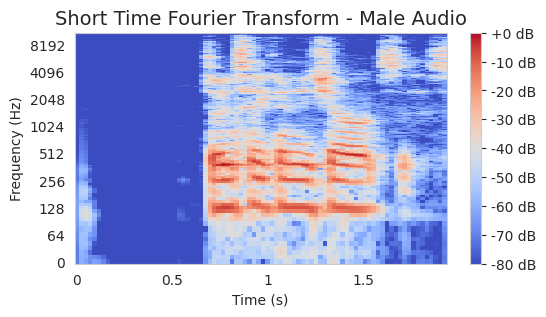

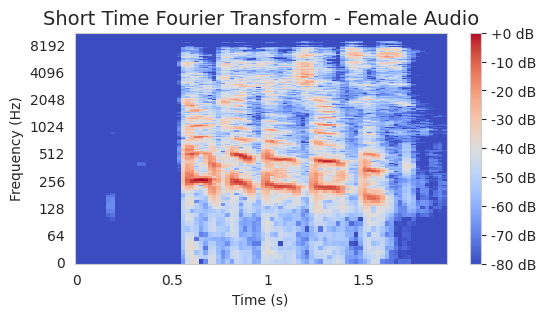

None

None

In [47]:
ipd.display(
    plot_stft(
        audio = audio_male,
        sr = sr_male,
        title = "Short Time Fourier Transform - Male Audio"
    ),
    plot_stft(
        audio = audio_female,
        sr = sr_female,
        title = "Short Time Fourier Transform - Female Audio"
    )
)


- In all spectrogram plots, the color represents the amount (loudness/volume) of a given frequency, at a given timepoint. +0dB is the loudest, and -80dB is close to silence. On the horizontal x-axis we can see the time, while on the vertical y-axis we can see the different frequencies.


- This plot shows, that the female voice is generally stronger on the higher frequencies (256-512Hz) and the male voice is stronger in the lower (around 128Hz) frequencies.

<br>
<a name = "mel"></a>

#### The Mel Spectrogram

As an alternative to the STFT, we can also compute the mel spectrogram, which is based on the [mel scale](https://www.sfu.ca/sonic-studio-webdav/handbook/Mel.html). This scale accounts for the way we human perceive a sound’s pitch. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as having the same perceptual difference.

- The mel spectrogram is computed very similar to the STFT, the main difference is just that the y-axis uses a different scale.

In [48]:
def plot_mel_spectrogram(audio, sr, title):
    x_mel = librosa.feature.melspectrogram(y = audio, sr = sr)

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_mel = librosa.power_to_db(x_mel, ref = np.max)

    plt.figure(figsize = (6, 3))
    ld.specshow(x_mel, sr = sr, x_axis = "time", y_axis = "mel", cmap = "coolwarm")
    plt.colorbar(format = "%+2.0f dB")
    
    plt.title(title, fontsize = 14)
    plt.xlabel("Time (s)", fontsize = 10)
    plt.ylabel("Frequency (Hz)", fontsize = 10)
    plt.show()

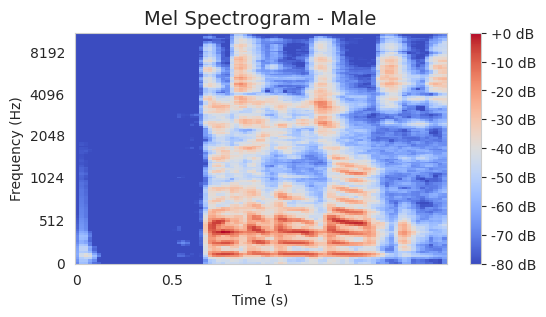

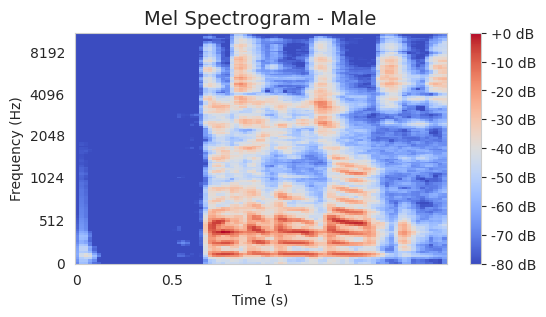

None

None

In [49]:
ipd.display(
    plot_mel_spectrogram(
        audio = audio_male,
        sr = sr_male,
        title = "Mel Spectrogram - Male"
    ),
    plot_mel_spectrogram(
        audio = audio_male,
        sr = sr_male,
        title = "Mel Spectrogram - Male"
    )
)

- The difference to the STFT might not be too obvious first, but if we take a closer look, we can see that in the STFT plot, the frequency from 0 to 512 Hz take much more space on the y-axis than in the Mel plot.

__Note: We are not going to explore all the audio features that we will use in our model in order to save some time and focus on the modelling. Later we will shortly introduce each feature with some general information of it.__

<br>


#### We saw how our audio features can help our model recognize the speaker's gender, let's now see how to extract those features in the fastest and most effective way.

<br>

<a name = "feature_ee"></a>
## 4. Feature Extraction & Engineering

In this part we will use the [pyAudioAnalysis](https://github.com/tyiannak/pyAudioAnalysis/wiki) library - an open-source Python library that provides a wide range of audio-related functionalities focusing on feature extraction, classification, segmentation and visualization issues.

There are two stages in the audio feature extraction methodology:

- __Short-term feature extraction__: It splits the input signal into short-term widnows (frames) and computes a number of features for each frame. This process leads to a sequence of short-term feature vectors for the whole signal.


- __Mid-term feature extraction__: In many cases, the signal is represented by statistics on the extracted short-term feature sequences described above. Towards this end, function mid_feature_extraction() from the MidTermFeatures.py file extracts a number of statistcs (e.g. mean and standard deviation) over each short-term feature sequence.


#### We will use the second type of extraction to gain more information from our data. Those are the implemented features that we will extract:

    1. Zero Crossing Rate  - The rate of sign-changes of the signal during the duration of a particular frame.

    2. Energy - The sum of squares of the signal values, normalized by the respective frame length.
    
    3. Entropy of Energy - The entropy of sub-frames' normalized energies. It can be interpreted as a measure of abrupt changes.
    
    4. Spectral Centroid - The center of gravity of the spectrum.
    
    5. Spectral Spread - The second central moment of the spectrum.
    
    6. Spectral Entropy - Entropy of the normalized spectral energies for a set of sub-frames.

    7. Spectral Flux - The squared difference between the normalized magnitudes of the spectra of the two successive frames.

    8. Spectral Rolloff - The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
    
    9. MFCCs - Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

    10. Chroma Vector - A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
    
    11. Chroma Deviation - The standard deviation of the 12 chroma coefficients.
    
<br>

#### First, we will need to convert our data to .wav format, because pyAudioAnalysis works much faster with that format (as a reference, the time estimated to extract the features for  500k of audios was over 1400 hours...).

In [69]:
def convert_mp3_to_wav(path):
    new_path = os.chdir(path)
    audio_files = os.listdir(new_path)

    for file in audio_files:
        # Split the file into the name and the extension
        name, extension = os.path.splitext(file)
        if extension == ".mp3":
            mp3_sound = AudioSegment.from_mp3(file)
           # Convert and rename the files using the old name + ".wav"
            mp3_sound.export("{0}.wav".format(name), format = "wav")
    
    os.chdir(CSV_PATH)

In [70]:
convert_mp3_to_wav(AUDIO_PATH)

KeyboardInterrupt: 

We will delete the mp3 files with the following function:

In [ ]:
def delete_mp3_files(path, data):

    os.chdir(path)
    audio_files = os.listdir()
    files_deleted = 0

    for file in audio_files:
        name, extension = os.path.splitext(file)
        if extension == ".mp3":
            os.remove(file)
            files_deleted += 1
            
    os.chdir(CSV_PATH)
    print(f"{files_deleted} .mp3 files deleted from this folder.")

<br>

#### Now let's go ahead and write a function to extract our mid-term features.

In [36]:
def mt_feature_extractor(path):
    features, files, feature_names = MTF.directory_feature_extraction(path, 1, 1, 0.1, 0.05)
    
    df = pd.DataFrame(features, columns = feature_names)
    df["filename"] = [file for file in files]
    
    return df

- We can now apply our function and extract all the features from the audio folder:

In [63]:
data_features = mt_feature_extractor(AUDIO_PATH)

Analyzing file 1 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100038.mp3
Analyzing file 2 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100040.mp3
Analyzing file 3 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100166.mp3
Analyzing file 4 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100168.mp3
Analyzing file 5 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100169.mp3
Analyzing file 6 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100170.mp3
Analyzing file 7 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100171.mp3
Analyzing file 8 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100172.mp3
Analyzing file 9 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100173.mp3
Analyzing file 10 of 515310: /home/faeron/Desk

Analyzing file 78 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100504.mp3
Analyzing file 79 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100507.mp3
Analyzing file 80 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10051.mp3
Analyzing file 81 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100511.mp3
Analyzing file 82 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100515.mp3
Analyzing file 83 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100516.mp3
Analyzing file 84 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10052.mp3
Analyzing file 85 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10053.mp3
Analyzing file 86 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10054.mp3
Analyzing file 87 of 515310: /home/faeron

Analyzing file 154 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_1009486.mp3
Analyzing file 155 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_1009487.mp3
Analyzing file 156 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_1009489.mp3
Analyzing file 157 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_1009490.mp3
Analyzing file 158 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_1009491.mp3
Analyzing file 159 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10095.mp3
Analyzing file 160 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100950.mp3
Analyzing file 161 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100952.mp3
Analyzing file 162 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_100953.mp3
Analyzing file 163 of 51

Analyzing file 230 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101104.mp3
Analyzing file 231 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101105.mp3
Analyzing file 232 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101106.mp3
Analyzing file 233 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101107.mp3
Analyzing file 234 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101108.mp3
Analyzing file 235 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101109.mp3
Analyzing file 236 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101110.mp3
Analyzing file 237 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101111.mp3
Analyzing file 238 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101112.mp3
Analyzing file 239 of 515310

Analyzing file 306 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101384.mp3
Analyzing file 307 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101385.mp3
Analyzing file 308 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101386.mp3
Analyzing file 309 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101387.mp3
Analyzing file 310 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101388.mp3
Analyzing file 311 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101389.mp3
Analyzing file 312 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101390.mp3
Analyzing file 313 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101391.mp3
Analyzing file 314 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101392.mp3
Analyzing file 315 of 515310

Analyzing file 382 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101459.mp3
Analyzing file 383 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101460.mp3
Analyzing file 384 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101461.mp3
Analyzing file 385 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101462.mp3
Analyzing file 386 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101463.mp3
Analyzing file 387 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101464.mp3
Analyzing file 388 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101465.mp3
Analyzing file 389 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101466.mp3
Analyzing file 390 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101467.mp3
Analyzing file 391 of 515310

Analyzing file 458 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101703.mp3
Analyzing file 459 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101706.mp3
Analyzing file 460 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101708.mp3
Analyzing file 461 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10171.mp3
Analyzing file 462 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101712.mp3
Analyzing file 463 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_101714.mp3
Analyzing file 464 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10172.mp3
Analyzing file 465 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10174.mp3
Analyzing file 466 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10178.mp3
Analyzing file 467 of 515310: /h

Analyzing file 534 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208636.mp3
Analyzing file 535 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208637.mp3
Analyzing file 536 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208638.mp3
Analyzing file 537 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208639.mp3
Analyzing file 538 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208640.mp3
Analyzing file 539 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208641.mp3
Analyzing file 540 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208642.mp3
Analyzing file 541 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208643.mp3
Analyzing file 542 of 515310: /home/faeron/Desktop/ML Exam Project/data/en/clips/common_voice_en_10208644.mp3
Analyzing 

ValueError: zero-size array to reduction operation maximum which has no identity

- And finally, let's save the new .csv files, so we don't need to execute the previous functions anew...

In [ ]:
data_features.to_csv("data_features.csv", index = False)

In [ ]:
data_features = pd.read_csv("audio_data_features.csv")

In [ ]:
data_features.head()

Next steps:

1. Merge the features and the gender datasets.


2. See if our extraction produced some missing values and handle them.


3. Decide what to do with outliers.


In [ ]:
cols_to_drop = ["filename", "down_votes"]

In [ ]:
final_data[final_data.isna().any(axis = 1)]


- Now we can also replace the gender values into a more understandable format for our models:

In [ ]:
def replace_gender(data):
    data.gender.replace(["female", "male"], [0, 1], inplace = True)
    return data

In [ ]:
final_data = replace_gender(final_data)

In [ ]:
final_data.gender.unique()

In [ ]:
final_data.gender.value_counts()

As a final step of the cleaning will be good to handle the outliers.

__Note: There are too many features to observe in order to understand the outlier situation better and decide either to remove or replace them. We also need deep understanding of all the audio features which we might not have enough to understand what is actually an outlier in this data and which outliers will be useful.__

__For the purpose of keeping things as simple as possible we can skip that part and use the whole dataset as it is.__



In [ ]:
final_data.to_csv("final_data.csv", index = False)

## Model Selection - Determining the proper type of algorithm for our problem:


In this section, we will test different types of models to see which one is best for our data. We will test a common representative of each of the following types: __Ensemble, Regresion, Bayesian, SVM, Instance Based, Neural Network:__

- [**LGBM Classifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) - an ensemble estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.


- [**Logistic Regression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) -  predicts a dependent data variable by analyzing the relationship between one or more existing independent variables.


- [**Gaussian Naive Bayes**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) -  a classification technique used in Machine Learning (ML) based on the probabilistic approach and Gaussian distribution.


- [**SVC (Support Vector Classifier)**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) - Since the separating hyperplane is supported (defined) by the vectors (data points) nearest the margin, so the algorithm is called SVM. SVM has been shown to perform well in many real learning problems with a variety of settings and is often considered one of the best “out-of-the-box” classifiers.


- [**K-Neighbors Classifier**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) - a classifier implementing the k-nearest neighbors vote, if it is found that two neighbors, neighbor k+1 and k, have identical distances but different labels, the results will depend on the ordering of the training data


- [**Perceptron**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) - one of the earliest machine learning techniques and still from the foundation of many modern neural networks. 

<br>

It will be useful to observe how each of the baseline models perform to use as a reference. We will just scale the features (because some algorithms require it, and the rest will not be affected by it), and define a few parameters to speed up the test, no additional tuning.

In [ ]:
final_data = pd.read_csv("final_data.csv")

In [ ]:
final_data.shape

- We are left with 302,329 observations and 139 features in our balanced dataset, where we've selected the best representations of all the original and augmented data.

In [ ]:
def baseline_accuracy_with_scaling(model, data, to_drop, target):
    test_label = data[target]
    test_features = data.drop(columns = to_drop, axis = 1)

    x_train, x_test, y_train, y_test = train_test_split(test_features, test_label, test_size = 0.1)

    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    classifier = model
    classifier.fit(x_train_scaled, y_train)

    model_name = str(type(model)).split(".")[-1].replace("'", "").replace(">", "")
    
    train_acc = round(classifier.score(x_train_scaled, y_train), 3)
    test_acc = round(classifier.score(x_test_scaled, y_test), 3)
    
    result = [model_name, train_acc, test_acc]
    return result

In [ ]:
def test_baseline_models(models, data, to_drop, target, csv_name):
    results = list()
    for model in models:
        results.append(baseline_accuracy_with_scaling(model = model, data = data, to_drop = to_drop, target = target))
        
    baseline_results = pd.DataFrame(results, columns = ["Model", "Train Accuracy", "Test Accuracy"])
    baseline_results.to_csv(csv_name, index = False)

- To save computing time, but still, get a picture of the performance, we can predefine some hyperparameters

In [ ]:
def plot_model_test(data, x, hue, y, figsize, title, x_label, y_label):
    
    plt.figure(figsize = figsize)
        
    ax = sns.barplot(x = x, hue = hue, y = y, data = data, palette = colors, dodge = False)

    plt.title(title, fontsize = 14)
    plt.xlabel(x_label, fontsize = 10)
    plt.ylabel(y_label, fontsize = 10)

    ax.legend_.remove()
    
    plt.show()

In [ ]:
test_baseline_models(
    models = [
        LGBMClassifier(n_estimators = 100, n_jobs = -1), 
        LogisticRegression(solver = "liblinear", n_jobs = -1), 
        GaussianNB(),
        SVC(),
        KNeighborsClassifier(n_jobs = -1),
        Perceptron(n_jobs = -1)
    ], 
    data = final_data,
    to_drop = "gender",
    target = "gender",
    csv_name = "baseline_results.csv"
)

In [ ]:
baseline_results = pd.read_csv("baseline_results.csv")

In [ ]:
plot_model_test(
    data = baseline_results.sort_values("Test Accuracy", ascending = False),
    x = "Test Accuracy",
    y = "Model",
    hue = "Model",
    figsize = (10, 6),
    title = "Comparisson of Baseline Models",
    x_label = "Accuracy",
    y_label = "Model"
)

In [ ]:
baseline_results

Obviously, Random Forest outperforms the others and the rest of the models are not performing very well.

Further, we will test two different ensemble models, and we will select the best one among them.

#### We will compare two bagging and two boosting classifiers and select the one that performs best without tuning (n_estimators = 100 will be selected for all of them to ensure equality in the number of trees):

In [ ]:
test_data = pd.read_csv("balanced_audio_data.csv")

In [ ]:
test_data.gender.value_counts()

In [ ]:
test_baseline_models(
    models = [
        CatBoostClassifier(n_estimators = 100),
        XGBClassifier(n_estimators = 100),
        LGBMClassifier(n_estimators = 100),
    ],  
    data = test_data,
    to_drop = "gender",
    target = "gender",
    csv_name = "ensemble_baseline_results.csv"
)

In [ ]:
ensemble_baseline_results = pd.read_csv("ensemble_baseline_results.csv")

In [ ]:
plot_model_test(
    data = ensemble_baseline_results,
    x = "Test Accuracy",
    y = "Model",
    hue = "Model",
    figsize = (10, 6),
    title = "Comparisson of Ensemble Baseline Models",
    x_label = "Accuracy",
    y_label = "Model"
)

In [ ]:
ensemble_baseline_results

The outcome of this test shows us that ExtraTreesClassifier performs better than the rest, the difference is quite significant.

We will use ExtraTrees as our main model in this project not only because it performs better in terms of accuracy, but also is faster than RandomForest.

- This algorithm saves time because the whole procedure is the same, but it randomly chooses the split point and does not calculate the optimal one. 

## Model Tuning

It is time to tune our model and see how far it could go.

__Note: We will train and test the model only on the large datasets that we've created previously.__

#### First, let's discuss the steps:

1. We will split the data on training and testing sets. To avoid “wasting” too much training data in validation sets, a common technique is to use cross-validation (ideally 10-fold). As Kuhn & Johnson mention about the choice of k value in their book:

    "The choice of k is usually 5 or 10, but there is no formal rule. As k gets larger, the difference in size between the training set and the resampling subsets gets smaller. As this difference decreases, the bias of the technique becomes smaller (i.e., the bias is smaller for k = 10 than k = 5). In this context, the bias is the difference between the estimated and true values of performance"
    

2. Then we will create our model including the following steps in a pipeline:

    2.1. - **Normalizing or Standardization**? Actually, ExtraTrees, or any ensemble where the base learner is a tree, don't require scaling. That's a property of tree based models, but in order to reduce the dimensions of our data with PCA we will need to scale our data as this algorithm requires it.

    2.2. **Dimensionality reduction (PCA)** - To deal with overfitting: it reduces the model’s complexity and also removes some noise in the data. We will also reduce the deal with the multicolinearity problem in this way.
    
    2.3. **LGBM Classifier** - We will optimize the model by cross-validation and check different metrics to see how it performs.


<br>

### Data Splitting

- Before continuing, let's make a quick check for duplicates. It is curious to see if some identical observations were created when oversampling our data.

In [ ]:
final_data[final_data.duplicated()].value_counts().sum()

In [ ]:
final_data = final_data[~final_data.duplicated()]

- 4 duplicates removed, we can continue and split our train and test data, using a sample of 2,343 observations for the test and leaving 270,000 for training.


In [ ]:
gender_label = final_data.gender
audio_features = final_data.drop(columns = ["gender"], axis = 1)

features_train, features_test, target_train, target_test = train_test_split(
                                                                audio_features, 
                                                                gender_label, 
                                                                test_size = 2343
                                                                )

### Feature importances

If we want to see which features are most important to the Extra Trees model to predict the gender from our audio data, we can visualize and quantify the importances:

In [ ]:
extra_trees = ExtraTreesClassifier(n_estimators = 100, n_jobs = -1)
et_importances_model = extra_trees.fit(features_train, target_train)

In [ ]:
features = {}
for feature, importance in zip(features_train.columns, et_importances_model.feature_importances_):
    features[feature] = importance

importances = pd.DataFrame.from_dict(features, orient = "index").rename(columns = {0: "Gini - Importance"})
importances = importances.sort_values(by = "Gini - Importance", ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns = {"index": "Features"})

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

sns.barplot(x = importances["Gini - Importance"].nlargest(10), y = importances["Features"][:10], data = importances, palette = colors)

plt.title("Feature Importance", fontsize = 14)
plt.xlabel("Importance", fontsize = 10)
plt.ylabel("Features", fontsize = 10)

display(plt.show())
display(importances.nlargest(10, columns = "Gini - Importance"))

#### Key Findings:

- Obviously, the mel spectrogram features are the most important to determine the gender of our speaker, leading with mfcc_13 which shows the energy of the audio. Therefore, the energy is the most important factor to differentiate between the gender.

- The rest of the features represent the [cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) of the signal.

<br>

We can try to select our features manually and exctract a certain ammount of them, but there is a better option - instantiate a PCA function and set the number of components (features) that we want to consider.

- Let's first scale our features, because they need to be scaled for PCA:

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(audio_features)

In [ ]:
pca_test = PCA(n_components = 138)
pca_test.fit(features_scaled)

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))


plt.axhline(linewidth = 2, color = "r", linestyle = "--", y = 0.95, xmin = 0, xmax = 138)
plt.axvline(linewidth = 2, color = "r", linestyle = "--", x = 73, ymin = 0, ymax = 1)

plt.xlabel("Number of components", fontsize = 10)
plt.ylabel("Cumulative explained variance", fontsize = 10)
plt.title("Components vs Variance", fontsize = 14)

display(plt.show())

Looking at the plot above, when we use PCA to reduce our 138 predicting variables down to 73, we can still explain around 95% of the variance. 

- The other 65 features we have explain 5% of the variance, so we can remove them. Using this logic, we will use PCA and integrate it to our pipeline to reduce the features.


- This visualization definitely saved us some time, we wouldn't need to fine-tune PCA and create a pipeline, we can just set n_components to 73:

<br>

## Model Optimization

Now that we've learned more about our features, it is time to train, test, and optimize.

- First step is to defined a cross-validation function, using the experimental [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) from sklearn to save some time, it is said to perform over 10 times faster than the normal [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [ ]:
def halving_grid_search(x_train, y_train, model, param_grid, cv):

    grid = HalvingGridSearchCV(
    model,
    param_grid,
    cv = cv,
    scoring = "accuracy",
    resource = "n_samples",
    n_jobs = -1,
    random_state = 42,
    verbose = 1,
    factor = 2,
    )
    model = grid.fit(x_train, y_train)

    best_score = np.round(model.best_score_, 3)
    best_params = model.best_params_

    return model

<br>

### Now... Let's build our Pipeline!

The most important hyper-parameters of a Random Forest that can be tuned and those known for helping us reduce overfitting are:


- **n_estimators** - this is the number of trees we want to build before taking the maximum voting or averages of predictions. Higher number of trees = better performance = more computational time.


- **criterion** - the criteria with which to split on each node (Gini or Entropy for a classification task, or the MSE or MAE for regression).


- **min_samples_leaf** - leaf is the end node of a decision tree. A smaller leaf makes the model more prone to capturing noise in train data.



- **min_samples_split** - the minimum number of observations required before a node of a tree can split itself.


- **max_features** - The number of features to consider when looking for the best split.


<br>

#### Defining the base pipeline and the parameter grid:

It is important to know that we can get a good range of values for our grid by creating a bar plot of each hyperparameter on the x-axis, and the mean score of the models made at each value. This way we can see which approximate values were most successful on average and then fine tune them.

- So let's create our pipeline and cross-validate with a given set of values:

In [ ]:
pipeline_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", PCA(n_components = 75)),
    ("classifier", SVC(max_iter = 10000))
])

In [ ]:
pipeline_1 = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", PCA(n_components = 73)),
    ("classifier", LGBMClassifier(
                        n_estimators = 10000,
                        n_jobs = -1, 
                        random_state = 42,
    ))
])

In [ ]:
pipeline_svc.fit(features_train, target_train)
 
print('Training set score: ' + str(pipeline_svc.score(features_train, target_train)))
print('Test set score: ' + str(pipeline_svc.score(features_test, target_test)))

As we can see, our model is most probab

In [ ]:
param_grid_1 = {
    "scaler": [StandardScaler(), MinMaxScaler(), MaxAbsScaler()],
    "classifier__n_estimators": [100, 250, 500],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__min_samples_leaf": [2, 4, 6],
    "classifier__min_samples_split": [3, 5, 7],
    "classifier__max_features": [0.1, "sqrt", "log2"]
}

In [ ]:
# model_tuning_1 = halving_grid_search(
#     x_train = features_train, 
#     y_train = target_train, 
#     model = pipeline_1, 
#     param_grid = param_grid_1, 
#     cv = 5,
# )

In [ ]:
# model_tuning_1_results = pd.DataFrame(model_tuning_1.cv_results_).sort_values("mean_test_score", ascending = False).reset_index(drop = True)
# model_tuning_1_results = model_tuning_1_results[[
#     "n_resources",
#     "param_scaler",
#     "param_classifier__n_estimators", 
#     "param_classifier__criterion",  
#     "param_classifier__min_samples_leaf", 
#     "param_classifier__min_samples_split", 
#     "param_classifier__max_features", 
#     "rank_test_score", 
#     "mean_test_score", 
#     "mean_train_score"
# ]]

In [ ]:
# model_tuning_1_results.to_csv("model_tuning_1_results.csv")

In [ ]:
model_tuning_1_results = pd.read_csv("model_tuning_1_results.csv")
model_tuning_1_results.head(5)

#### Key Findings:

We can see that the higherst scores come with the highest n_resources (number of observations used in the validation). This means that our model works best with high amounts of data, and its performance drops if data is less than the maximum in this dataset.

1. n_estimators - the highest value gave the best results, and we can try even higher in the next round.

2. criterion - we can still explore this performance.

3. min_samples_leaf - 2 is the minimum that we can select here, so we can check how it performs with the value of 3 as well.

4. min_samples_split - 3 and 5 seem to be the best fit, but we can check also 4 in the next test.

5. max_features - we will continue exploring with the same values.

6. scaler - MaxAbsScaler seems to outperform the rest significantly, but let's see if this will change.

In [ ]:
param_grid_2 = {
    "scaler": [StandardScaler(), MinMaxScaler(), MaxAbsScaler()],
    "classifier__n_estimators": [500, 1000, 1500],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__min_samples_leaf": [2, 3, 4],
    "classifier__min_samples_split": [3, 4, 5],
    "classifier__max_features": [0.1, "sqrt", "log2"]
}

In [ ]:
# model_tuning_2 = halving_grid_search(
#     x_train = features_train, 
#     y_train = target_train, 
#     model = pipeline_1, 
#     param_grid = param_grid_2, 
#     cv = 5,
# )

In [ ]:
# model_tuning_2_results = pd.DataFrame(model_tuning_2.cv_results_).sort_values("mean_test_score", ascending = False).reset_index(drop = True)
# model_tuning_2_results = model_tuning_2_results[[
#     "n_resources",
#     "param_scaler",
#     "param_classifier__n_estimators", 
#     "param_classifier__criterion", 
#     "param_classifier__min_samples_leaf", 
#     "param_classifier__min_samples_split", 
#     "param_classifier__max_features", 
#     "rank_test_score", 
#     "mean_test_score", 
#     "mean_train_score"
# ]]

In [ ]:
# model_tuning_2_results.to_csv("model_tuning_2_results.csv")

In [ ]:
model_tuning_2_results = pd.read_csv("model_tuning_2_results.csv")
model_tuning_2_results.head(5)

#### Key Findings:

There was a slight improvement in the scores.


1. n_estimators - the higher - the better, for now, let's get them up to 4500 in the next run.

2. min_samples_leaf will be tested at 1, 2, 3

3. min_samples split will be tested at 2, 3 and 4.

The rest will stay the same.

In [ ]:
param_grid_3 = {
    "scaler": [StandardScaler(), MinMaxScaler(), MaxAbsScaler()],
    "classifier__n_estimators": [1500, 3000, 4500],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__min_samples_leaf": [1, 2, 3],
    "classifier__min_samples_split": [2, 3, 4],
    "classifier__max_features": [0.1, "sqrt", "log2"]
}

In [ ]:
# model_tuning_3 = halving_grid_search(
#     x_train = features_train, 
#     y_train = target_train, 
#     model = pipeline_1, 
#     param_grid = param_grid_3, 
#     cv = 5,
# )

In [ ]:
# model_tuning_3_results = pd.DataFrame(model_tuning_3.cv_results_).sort_values('mean_test_score').reset_index(drop = True)
# model_tuning_3_results = model_tuning_3_results[[
#     "n_resources",
#     "param_scaler",
#     "param_classifier__n_estimators", 
#     "param_classifier__criterion", 
#     "param_classifier__min_samples_leaf", 
#     "param_classifier__min_samples_split", 
#     "param_classifier__max_features", 
#     "rank_test_score", 
#     "mean_test_score", 
#     "mean_train_score"
# ]]

In [ ]:
# model_tuning_3_results.to_csv("model_tuning_3_results.csv")

In [ ]:
model_tuning_3_results = pd.read_csv("model_tuning_3_results.csv")
model_tuning_3_results.head(5)

#### Key Findings:

Again, there is a bit of improvement here,

- n_estimators - apparently there's hardly any difference between 1500 and 4500 estimators.

- min_samples_leaf - the default value of 1 is the best one in this test.

- min_samples_split - the results cannot really show us if 3 is better than 2.

- max_features - log2 gave more consistent results for the previous test, but it didn't performed so great here.


#### We can now now concatenate all 3 test results into one dataframe and visualize the parameters to gain more insight of the bigger picture:

In [ ]:
datasets = [model_tuning_1_results, model_tuning_2_results, model_tuning_3_results]
merged_tuning_results = pd.concat(datasets)
merged_tuning_results.reset_index(drop = True).to_csv("merged_tuning_results.csv")

In [ ]:
merged_tuning_results = pd.read_csv("merged_tuning_results.csv")

In [ ]:
merged_tuning_results.shape

We have 2919 results from which we can select the top 10 performing models and visualize the parameters:

In [ ]:
data = merged_tuning_results.nlargest(10, "mean_test_score")
fig, axs = plt.subplots(ncols = 3, nrows = 2)

fig.set_size_inches(16, 10)

sns.barplot(x = "param_classifier__n_estimators", y = "mean_test_score", data = data, ax = axs[0, 0], color = "#FF9CEE")
axs[0, 0].set_title(label = "n_estimators", size = 12)

sns.barplot(x = "param_classifier__criterion", y = "mean_test_score", data = data, ax = axs[0, 1], color = "#85E3FF")
axs[0, 1].set_title(label = "criterion", size = 12)

sns.barplot(x = "param_classifier__min_samples_leaf", y = "mean_test_score", data = data, ax = axs[0, 2], color = "#AFF8DB")
axs[0, 2].set_title(label = "min_samples_leaf", size = 12)

sns.barplot(x = "param_classifier__min_samples_split", y = "mean_test_score", data = data, ax = axs[1, 0], color = "#E7FFAC")
axs[1, 0].set_title(label = "min_samples_split", size = 12)

sns.barplot(x = "param_classifier__max_features", y = "mean_test_score", data = data, ax = axs[1, 1], color = "#FFABAB")
axs[1, 1].set_title(label = "max_features", size = 12)

sns.barplot(x = "param_scaler", y = "mean_test_score", data = data, ax = axs[1, 2], color = "#FFCBC1")
axs[1, 2].set_title(label = "scaler", size = 12)

plt.show()

#### Key Findings:

1. Our model seems to perform best with 1500 estimators, this will be a good value to use as it is big enough to help with overfitting prevention and small enough to make our model relatively fast.


2. Gini is definitely better than entropy in this case, and even though it can give similar results in some of the tests we will use it, because it is much less computationally expensive as well.


3. min_samples_leaf helps reduce or prevent overfitting, the higher the value, the better. In our case we can select 2.


4. min_samples_split - Having a default value as 2 poses the issue that a tree often keeps on splitting until the nodes are completely pure. As a result, the tree grows in size and therefore overfits the data. Hence, the higher its value, the lower the risk of overfitting - let's go with 5 here.


5. This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting. In our case log2 of 75 features means that each tree will be assignem approximately 6 features, which is quite a good number to reduce overfitting risk.


6. MaxAbsScaler has no competition here - this estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.


<br>

__Note:__

We will perform one more test, to see if our model will perform good with limited amounts of features, we will tune the PCA function so it reduces to achieve this.

What PCA does it to calculate linear combinations of our variables in such way that they get "summarized" in fewer variables.

In [ ]:
rfc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", PCA()),
    ("classifier", RandomForestClassifier(
                        n_estimators = 1500,
                        criterion = "gini",
                        bootstrap = True,
                        min_samples_leaf = 2,
                        min_samples_split = 5,
                        max_features = "log2",
                        # max_samples = 0.6,
                        n_jobs = -1, 
                        random_state = 42, 
                        oob_score = True, 
                        warm_start = True
                    ))
])

In [ ]:
# param_grid_4 = {
#     "selector__n_components": [60, 70]
# }

In [ ]:
# model_tuning_4 = halving_grid_search(
#     x_train = features_train, 
#     y_train = target_train, 
#     model = rfc_pipeline, 
#     param_grid = param_grid_4, 
#     cv = 5,
# )

In [ ]:
# model_tuning_4_results = pd.DataFrame(model_tuning_4.cv_results_).sort_values('mean_test_score').reset_index(drop = True)
# model_tuning_4_results = model_tuning_4_results[[
#     "n_resources",
#     "param_selector__n_components",
#     "rank_test_score", 
#     "mean_test_score", 
#     "mean_train_score"
# ]]

# model_tuning_4_results.to_csv("model_tuning_4_results.csv")

In [ ]:
model_tuning_4_results = pd.read_csv("model_tuning_4_results.csv")
model_tuning_4_results.sort_values("mean_test_score", ascending = False).head(2)

#### Key Findings:

- There is some decrease in the performance by minimizing the number of components of PCA, so we can stick to our 75 components that describe 95% of the variance of our data.

### Model Training and Evaluation

We can configure our pipeline and test it with different metrics to see how it performs and where are its weak spots.

- First, let's define a couple of useful functions for our visualizations:

In [ ]:
def plot_confusion(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    cm_flat = cm.flatten()

    true_pos = cm_flat[0]
    false_pos = cm_flat[1]
    false_neg = cm_flat[2]
    truen_neg = cm_flat[3]

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1_score = 2 * precision * recall / (precision + recall)
    print("Precision: " + str(precision) + "\nRecall: " + str(recall) + "\nF1 Score: " + str(f1_score))
    
    group_counts = [str(value) for value in cm_flat]
    f, ax = plt.subplots(figsize = (10, 8))

    group_names = ["True Negative","False Positive","False Negative","True Positive"]
    labels = [v1 + "\n" + v2 for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot = labels, fmt = "", ax = ax, cmap = colors)

    plt.title("Confusion Matrix of " + model_name)
    plt.xlabel("Prediction")
    plt.ylabel("True")
    
    plt.show()

In [ ]:
def plot_learning_curve(pipe, scoring, x_train, y_train, title, metric):
    train_sizes, train_scores, test_scores = learning_curve(
                                                estimator = pipe,
                                                X = x_train,
                                                y = y_train,
                                                train_sizes = np.linspace(0.01, 1.0, 10),
                                                cv = 10,
                                                n_jobs = -1,
                                                random_state = 42,
                                                scoring = scoring
                                            )

    # Mean value of accuracy against training data
    train_mean = np.mean(train_scores, axis = 1)

    # Standard deviation of training accuracy per number of training samples
    train_std = np.std(train_scores, axis = 1)

    # Same as above for test data
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    
    plt.figure(figsize = (10, 5))

    plt.plot(train_sizes, train_mean, color = m_color, marker = "o", label = "Train")
    plt.fill_between(
        train_sizes,
        train_mean + train_std,
        train_mean - train_std,
        alpha = 0.15, color = m_color)

    plt.plot(train_sizes, test_mean, color = f_color, linestyle = "--", marker = "s", label = "Test")
    plt.fill_between(
        train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        alpha = 0.15, color = f_color)
    
    plt.title(title, fontsize = 14)
    plt.xlabel("Number of training samples", fontsize = 10)
    plt.ylabel(metric, fontsize = 10)
    plt.legend()
    
    plt.show()

__Note:__

We have added three additional parameters to our classifier to improve its performance:


1. bootstrap - a statistical resampling technique that involves random sampling of a dataset with replacement. It is often used as a means of quantifying the uncertainty associated with a machine learning model.


2. oob_score - whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap = True.


3. warm_start - when set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.


4. max_samples - if bootstrap is True, the number of samples to draw from X to train each base estimator. Actually we don't need to give all the samples to each tree, and we can try a run with 0.8 (80%) and see how it goes.


__Note:__

We will use n_estimators = 500, in order to save computational time,  the results with this parameter weren't so different than with 1500.

In [ ]:
gender_label = final_data_cleaned.gender
audio_features = final_data_cleaned.drop(columns = ["gender"], axis = 1)

features_train, features_test, target_train, target_test = train_test_split(audio_features, gender_label, test_size = 5000)

In [ ]:
rfc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", PCA(n_components = 90)),
    ("classifier", RandomForestClassifier(
                        n_estimators = 1500,
                        criterion = "gini",
                        bootstrap = True,
                        min_samples_leaf = 2,
                        min_samples_split = 5,
                        max_features = "log2",
                        # max_samples = 0.8,
                        n_jobs = -1, 
                        random_state = 42, 
                        oob_score = True, 
                        warm_start = True
                    ))
])

In [ ]:
rfc_pipeline.fit(features_train, target_train)
 
print('Training set score: ' + str(rfc_pipeline.score(features_train, target_train)))
print('Test set score: ' + str(rfc_pipeline.score(features_test, target_test)))

In [ ]:
rfc = RandomForestClassifier(n_jobs = -1).fit(features_train, target_train)
 
print('Training set score: ' + str(rfc.score(features_train, target_train)))
print('Test set score: ' + str(rfc.score(features_test, target_test)))

- The performance is nearly identical and generally, we get the same accuracy as with the "vanilla" Random Forest without any tuning

<br>

Now it will be useful to see a confusion matrix and evaluate the outcomes:

In [ ]:
rfc_classifier = rfc_pipeline.fit(features_train, target_train)
pred = rfc_classifier.predict(features_test)

plot_confusion(target_test, pred, "Random Forest Classifier")

#### Key Findings:

1. Our model tends to predict the 1 (male) class with higher accuracy, why would that be?

    - If we recall our target variable was imbalanced and we had much more observations of the male class, then we generated "artificially" more samples for the female class to balance the data. It could be that the features generated are not as accurate representation of the female class as the "organic" ones.
    
        - This means that our model will perform best if our data is balanced, otherwise we can get some "noise" in the minority class.
        

Let's see if we will get the same outcome with the "vanilla" RFC:

In [ ]:
rfc_classifier = RandomForestClassifier(n_jobs = -1).fit(features_train, target_train)
pred = rfc_classifier.predict(features_test)

plot_confusion(target_test, pred, "Random Forest Classifier")

#### Key Findings:

1. Slightly better performance in therms of accuracy and f1 score.

2. There is still more accuracy for the male class, showing us that the previous conclusions might've been correct. Apparently, the fault is not in the model, but in the data.

<br>

#### Now we come to a very important part in our project - let's evaluate if our model overfits, because it obviously doesn't underfit.

- We will plot a learning curve and evaluate it:

In [ ]:
plot_learning_curve(rfc_pipeline, "accuracy", features_train, target_train, "Random Forest Classifier", "Accuracy")

#### Key Findings:

1. Obviously, given the constant near to 100% accuracy shown by the train test curve - the training data is overfitted, why would that be? Random Forest is said to NOT overfit!!

    - Well, this statement is not entirely true, by leaving the max_depth parameter at None, there's no limit to the depth of the trees and this can cause significant overfitting in Random Forest.
    
    - We didn't tune it in the previous section, so that's what we get :)

2. The good part is that with the increase of data and number of estimators (trees) this problem is being reduced significantly. We can see that above 200,000 samples the results are much better.


Now let's see if the results are different with the "vanilla" classifier:


In [ ]:
plot_learning_curve(RandomForestClassifier(n_jobs = -1), "accuracy", features_train, target_train, "Random Forest Classifier", "Accuracy")

- Same results here... apparently the other parameters that we tuned doesn't reduce the overfitting in a significant way.

<br>

So, now, let's make a test with setting the max_depth to 5, this value is commonly believed and proven to reduce overfitting:

In [ ]:
rfc_depth_reduced = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", PCA(n_components = 75)),
    ("classifier", RandomForestClassifier(
                        n_estimators = 1500,
                        max_depth = 5,
                        criterion = "gini",
                        bootstrap = True,
                        min_samples_leaf = 2,
                        min_samples_split = 5,
                        max_features = "log2",
                        max_samples = 0.8,
                        n_jobs = -1, 
                        random_state = 42, 
                        oob_score = True, 
                        warm_start = True
                    ))
])

In [ ]:
# plot_learning_curve(rfc_depth_reduced, "accuracy", features_train, target_train, "Random Forest Classifier", "Accuracy")

#### Key Findings:

1. This is different now, we see much better learning curve, but... our accuracy gets stuck at the 0.65 range. And no matter ho much data we will feed to the model, the result will be the same.

2. We can conclude that our model needs more tree depth in order to give accurate predictions.